In [1]:
import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation

device='cpu'

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.phenotypes = None
        self.haplotypes = haplotypes
        self.dosages = haplotypes.sum(dim=1).float()
                
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean

        
def calculate_breeding_value(population_dosages, trait_effects, device = device):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape    
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    #crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny


def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population.dosages, trait.effects) 
    if breeding_values.var() == 0:
        print('phenotype: no var')
        environmental_variance = 0  
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var() 
    environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance.clone().detach())
    population.phenotypes = breeding_values + environmental_noise

#     def _create_random_haplotypes(self,num_individuals):
#         return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device= device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)
    
def create_progeny(mother_gametes, father_gametes,reps = 1):
    progeny = []
    for _ in range(reps):
        # Randomly shuffle the gametes from each parent 
        shuffled_mother_indices = torch.randperm(mother_gametes.shape[0])
        shuffled_father_indices = torch.randperm(father_gametes.shape[0])

        # Select the shuffled gametes
        mother_gametes = mother_gametes[shuffled_mother_indices]
        father_gametes = father_gametes[shuffled_father_indices]

        # Stack the gametes to create progeny haplotypes
        progeny_haplotypes = torch.stack((mother_gametes, father_gametes),dim=1)
        progeny.append(progeny_haplotypes)
    return torch.vstack(progeny)

# Function to run one generation
def run_generation(P, T, h2, reps, pop_size, selection_fraction):
    bv(P, T)  # Calculate breeding values
    phenotype(P, T, h2)  # Calculate phenotypes with given h2
    selected = P.haplotypes[torch.topk(P.phenotypes, int(pop_size * selection_fraction)).indices]  # Select top individuals based on phenotype
    m = recombine(selected)  # Mother gametes
    f = recombine(selected)  # Father gametes
    progeny = create_progeny(m, f, reps=reps)  # Create progeny
    new_population = Population(G, progeny)
    bv(new_population, T)  # Calculate breeding values for progeny
    phenotype(new_population, T, h2)  # Calculate phenotypes for progeny
    return new_population

In [2]:

# Parameters
pop_size = 200
h2 = 0.99
reps = 5
num_generations = 20

# Initialize genome and founder population
G = Genome(1, 1000)
P = create_pop(G, create_random_pop(G, pop_size))
T = Trait(G, P, 0, 1)

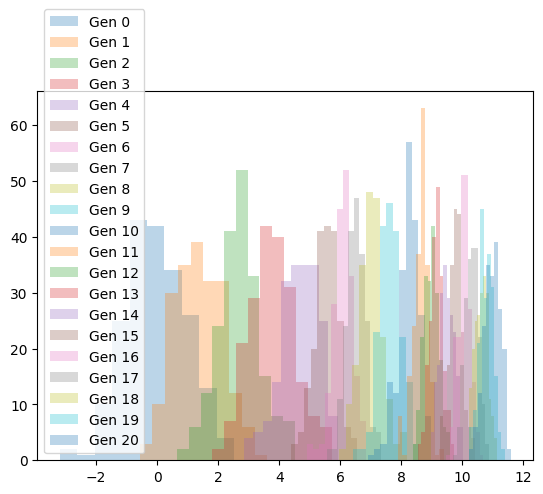

In [3]:


# Parameters
pop_size = 200
h2 = 0.99
reps = 5
num_generations = 20

# Initialize genome and founder population
G = Genome(1, 1000)
P = create_pop(G, create_random_pop(G, pop_size))
T = Trait(G, P, 0, 1)

# Store populations for plotting
pops = [P]

# Run multiple generations
for generation in range(num_generations):
    P = run_generation(P, T, h2, reps, pop_size, selection_fraction=1/reps)
    pops.append(P)

# Plot phenotypes for each generation
for i, P in enumerate(pops):
    plt.hist(P.phenotypes, alpha=0.3, label=f'Gen {i}')

plt.legend()

plt.show()

In [4]:
import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation

device='cpu'

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.haplotypes = haplotypes
        self.dosages = haplotypes.sum(dim=1).float()
        self.phenotypes = None
        self.breeding_values = None
                
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean

        
def calculate_breeding_value(population_dosages, trait_effects, device = device):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape    
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    #crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny


def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population.dosages, trait.effects) 
    if breeding_values.var() == 0:
        print('phenotype: no var')
        environmental_variance = 0  
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var() 
    environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance.clone().detach())
    population.phenotypes = breeding_values + environmental_noise

#     def _create_random_haplotypes(self,num_individuals):
#         return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device= device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)
    
def create_progeny(mother_gametes, father_gametes,reps = 1):
    progeny = []
    for _ in range(reps):
        # Randomly shuffle the gametes from each parent 
        shuffled_mother_indices = torch.randperm(mother_gametes.shape[0])
        shuffled_father_indices = torch.randperm(father_gametes.shape[0])

        # Select the shuffled gametes
        mother_gametes = mother_gametes[shuffled_mother_indices]
        father_gametes = father_gametes[shuffled_father_indices]

        # Stack the gametes to create progeny haplotypes
        progeny_haplotypes = torch.stack((mother_gametes, father_gametes),dim=1)
        progeny.append(progeny_haplotypes)
    return torch.vstack(progeny)


Generation 1: Avg Phenotype = 2.86, Reward = 2.86
Generation 2: Avg Phenotype = 2.22, Reward = 2.22
Generation 3: Avg Phenotype = 3.27, Reward = 3.27
Generation 4: Avg Phenotype = 3.42, Reward = 3.42
Generation 5: Avg Phenotype = 3.20, Reward = 3.20
Generation 6: Avg Phenotype = 4.05, Reward = 4.05
Generation 7: Avg Phenotype = 4.47, Reward = 4.47
Generation 8: Avg Phenotype = 5.42, Reward = 5.42
Generation 9: Avg Phenotype = 3.98, Reward = 3.98
Generation 10: Avg Phenotype = 5.88, Reward = 5.88


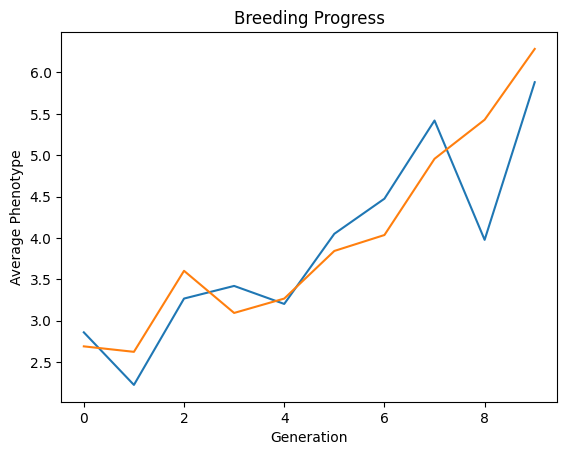

In [22]:

class BreedingSimulation:
    def __init__(self, G, T, h2, reps, pop_size, selection_fraction):
        self.G = G
        self.T = T
        self.h2 = h2
        self.reps = reps
        self.pop_size = pop_size
        self.selection_fraction = selection_fraction
        self.population = create_pop(G, create_random_pop(G, pop_size)) # Start with a random population
        self.history = []  # For tracking population data over generations

    def step(self, actions): # Actions will be provided by the RL agent
        selected_parent_indices = self.select_parents(actions)
        selected = self.population.haplotypes[selected_parent_indices]
        
        #breeding
        m = recombine(selected)  # Mother gametes
        f = recombine(selected)  # Father gametes
        progeny = create_progeny(m, f, reps=self.reps)  # Create progeny

        #phenotype
        self.population = update_pop(self.population, progeny)
        bv(self.population, self.T)
        phenotype(self.population, self.T, self.h2)

        # Calculate reward (e.g., genetic gain)
        reward = self.calculate_reward()

        # Track data for this generation
        self.track_data(actions, reward)

        return self.get_state(), reward

    def select_parents(self, actions):
        #the output from agent network will go into here.
        phenotype(self.population, self.T, self.h2)
        parents = torch.topk(self.population.phenotypes, actions).indices
        return parents

    def calculate_reward(self):
        # Define how to calculate the reward based on your objective. 
        # Example: Improvement in average trait value
        return self.population.phenotypes.mean()

    def get_state(self):
        # Define how to represent the state of the environment to the 
        # RL agent. You might return features like:
        # - Average trait value: self.population.phenotypes.mean()
        # - Genetic diversity metrics
        # - ...
        return self.population.phenotypes.mean() # Placeholder

    def track_data(self, actions, reward):
        gen_data = {
            'generation': len(self.history),
            'avg_phenotype': self.population.phenotypes.mean().item(),
            'phenotype_variance': self.population.phenotypes.var().item(),
            'avg_breeding_value': self.population.breeding_values.mean().item(),
            'actions': actions,  # You might want to log the actions taken
            'reward': reward.item()
        }
        self.history.append(gen_data)

    def plot_history(self):
        generations = [d['generation'] for d in self.history]
        avg_phenotypes = [d['avg_phenotype'] for d in self.history]
        actions = [d['avg_breeding_value'] for d in self.history]
        plt.plot(generations, avg_phenotypes)
        plt.plot(generations, actions)
        plt.xlabel('Generation')
        plt.ylabel('Average Phenotype')
        plt.title('Breeding Progress')
        plt.show()

# --- Example Usage ---
G = Genome(n_chr=7, n_loci=1000)
founder_pop_size = 2
founder_pop = create_pop(G, create_random_pop(G, founder_pop_size))
T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0)

sim = BreedingSimulation(G, T, h2=0.2, reps=2, pop_size=200, selection_fraction=0.5)

# Simulate 10 generations (replace this with your RL training loop)
for generation in range(10):
    # Placeholder: Generate random actions (you'll use your RL agent's policy here)
    actions = 5
    state, reward = sim.step(actions) 
    print(f"Generation {generation+1}: Avg Phenotype = {state:.2f}, Reward = {reward:.2f}")

sim.plot_history()

In [41]:
import torch
import torch.nn as nn

class CNN1D(nn.Module):
    def __init__(self, example_input):
        super(CNN1D, self).__init__()

        # Reshape example input to (batch, ploidy*chr, loci)
        example_input = example_input.view(example_input.size(0), -1, example_input.size(3))
        
        self.conv1 = nn.Conv1d(in_channels=example_input.size(1), out_channels=64, kernel_size=32, stride=8)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=8, stride=2)

        # Calculate the correct input size for fc1 based on the conv layer output sizes
        self._calculate_fc1_input_size(example_input)

        self.fc1 = nn.Linear(self.fc1_input_size, 64)
        self.fc2 = nn.Linear(64, 32)

    def _calculate_fc1_input_size(self, example_input):
        with torch.no_grad():
            x = self.conv1(example_input)
            x = self.conv2(x)
            self.fc1_input_size = x.numel() // x.size(0)  # Flattened size per batch element

    def forward(self, x):
        # Ensure input is of shape (batch, ploidy, chr, loci)
        assert x.ndimension() == 4, "Input should have shape (batch, ploidy, chr, loci)"
        
        # Reshape input to (batch, ploidy*chr, loci)
        x = x.view(x.size(0), -1, x.size(3))

        x1 = self.conv1(x)
        x1 = nn.ReLU()(x1)
        x1 = self.conv2(x1)
        x1 = nn.ReLU()(x1)
        x1 = x1.view(x1.size(0), -1)

        x2 = self.conv1(x.flip(dims=[1]))
        x2 = nn.ReLU()(x2)
        x2 = self.conv2(x2)
        x2 = nn.ReLU()(x2)
        x2 = x2.view(x2.size(0), -1)

        x = (x1 + x2) / 2
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

class MappingNetwork(nn.Module):
    def __init__(self):
        super(MappingNetwork, self).__init__()
        self.mapping = nn.Linear(1, 16)

    def forward(self, x):
        x = self.mapping(x)
        x = nn.ReLU()(x)
        return x
    
class CombinedModel(nn.Module):
    def __init__(self, example_geno_input):
        super(CombinedModel, self).__init__()
        self.geno_net = CNN1D(example_geno_input)
        self.meta_net = MappingNetwork()
        self.fc1 = nn.Linear(32 + 16, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()  # Add sigmoid layer

    def forward(self, geno_input, meta_input):
        geno_features = self.geno_net(geno_input)
        meta_features = self.meta_net(meta_input)
        combined_features = torch.cat((geno_features, meta_features), dim=1)
        x = self.fc1(combined_features)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = self.sigmoid(x)  # Apply sigmoid activation
        return x

# Example usage:
example_geno_input = torch.randn(8, 2, 22, 1000)  # Batch of 8, ploidy of 2, 22 chromosomes, 1000 loci
model = CombinedModel(example_geno_input)

# Use the model with actual inputs
geno_input = torch.randn(8, 2, 22, 1000)
meta_input = torch.randn(8, 1)
output = model(geno_input, meta_input)
print(output.shape)  # Output should have shape (8, 1)


torch.Size([8, 1])
